In [5]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [7]:
# Define meme stocks and paths
current_path = os.getcwd()
meme_stocks = ["RIVN", "BB", "SOFI", "GME", "AMC", "PLTR"]

stock_data = {}

for stock in meme_stocks:
    try:
        file_path = f"{current_path}/meme_stocks/{stock}_price_data.csv"
        data = pd.read_csv(file_path, index_col='Date', parse_dates=True)
        
        data['Amount'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4 * data['Volume']
        
        stock_data[stock] = data

    except Exception as e:
        print(f"Error loading data for {stock}: {str(e)}")

In [13]:
stock_data['RIVN']

,Open,High,Low,Close,Adj Close,Volume,Amount
Date,,,,,,,
2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500,1.094182e+10
2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200,9.844087e+09
2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800,6.570694e+09
2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300,9.100771e+09
2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600,1.572903e+10
...,...,...,...,...,...,...,...
2022-12-23,19.764999,19.770000,18.521999,19.139999,19.139999,18952000,3.657594e+08
2022-12-27,18.650000,18.700001,17.650000,17.740000,17.740000,21663000,3.939417e+08
2022-12-28,17.750000,18.260000,17.450001,17.740000,17.740000,20967700,3.732251e+08


Linear Regression

Stock: RIVN
Mean Squared Error: 1.7823899141065664e-18
R-squared: 1.0


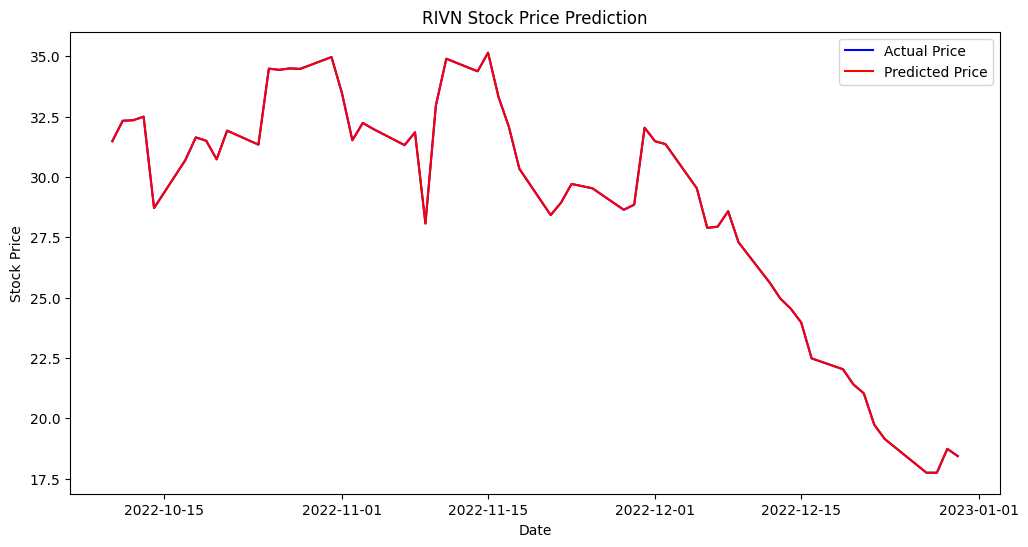

Stock: BB
Mean Squared Error: 7.705538467632587e-28
R-squared: 1.0


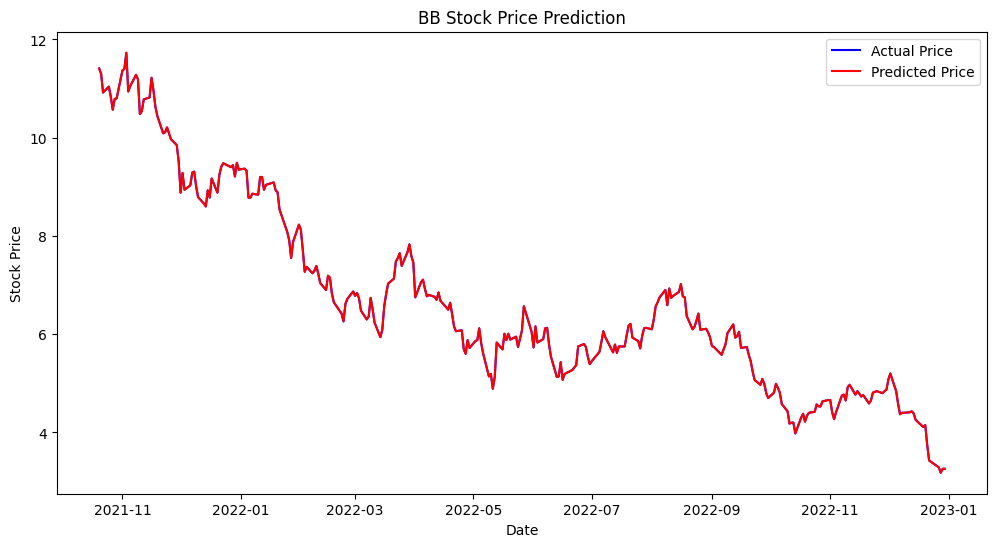

Stock: SOFI
Mean Squared Error: 1.0893783027888855e-24
R-squared: 1.0


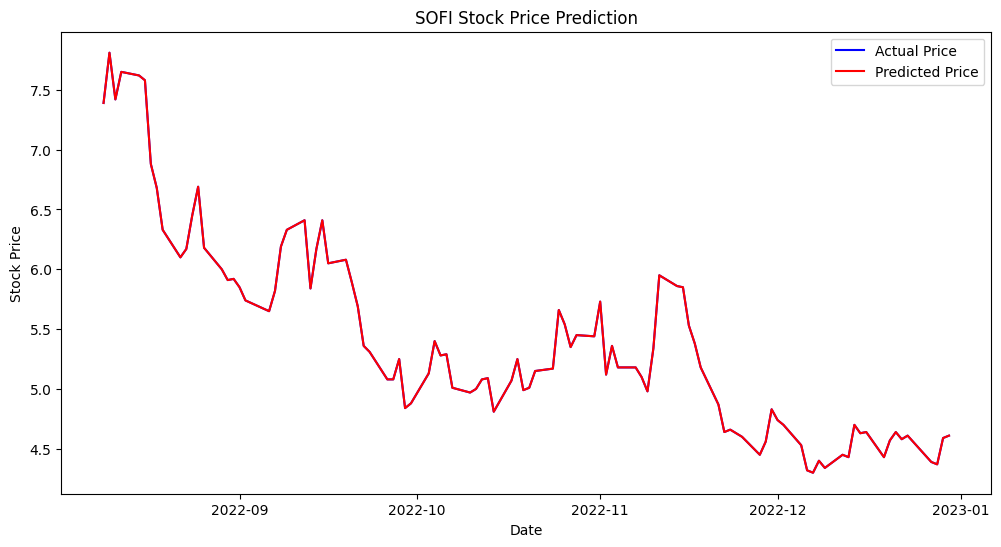

Stock: GME
Mean Squared Error: 6.130035602759329e-23
R-squared: 1.0


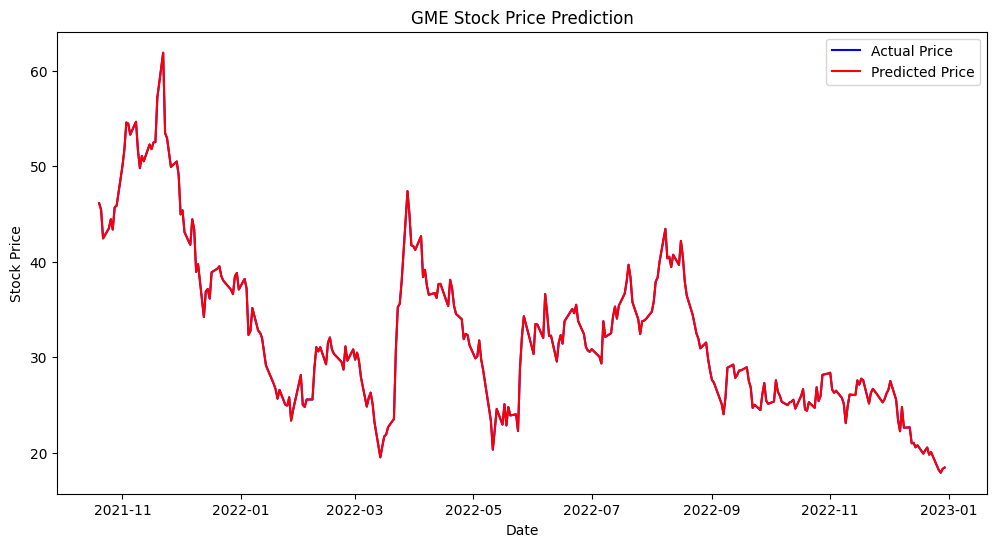

Stock: AMC
Mean Squared Error: 1.2944423818015988e-27
R-squared: 1.0


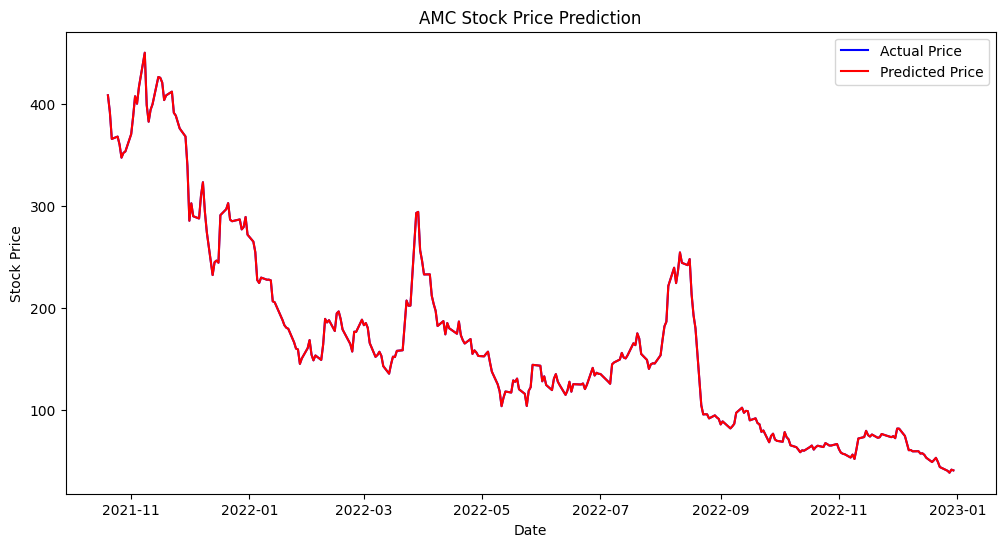

Stock: PLTR
Mean Squared Error: 5.580914678564846e-24
R-squared: 1.0


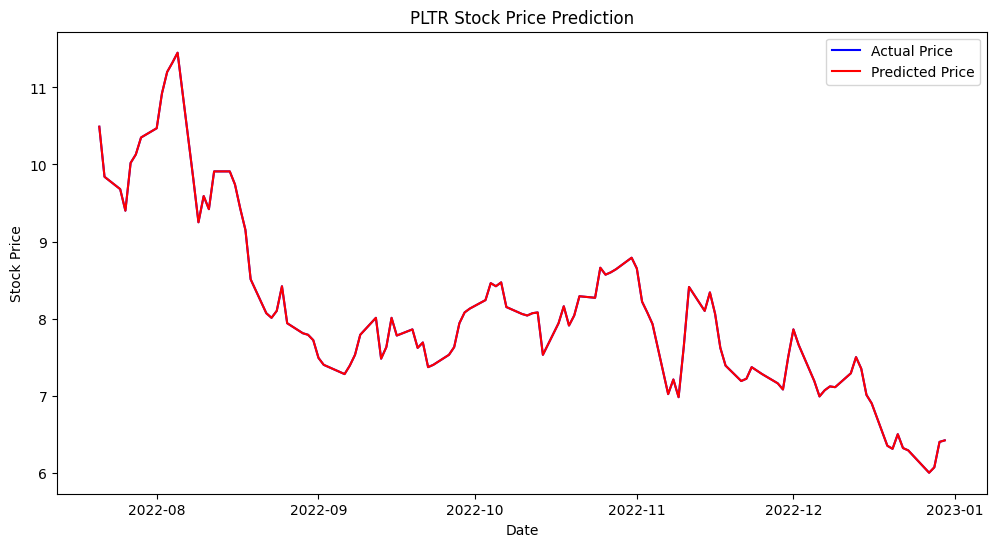

In [8]:
for stock, data in stock_data.items():
    train_size = int(0.8 * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]

    X_train = train_data[['Open', 'High', 'Low', 'Close', 'Volume']]
    y_train = train_data['Close']
    X_test = test_data[['Open', 'High', 'Low', 'Close', 'Volume']]
    y_test = test_data['Close']

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Stock: {stock}")
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, y_test, label='Actual Price', color='blue')
    plt.plot(test_data.index, y_pred, label='Predicted Price', color='red')
    plt.title(f"{stock} Stock Price Prediction")
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
